# Tracking Transient Residents in April 2020

The visit data from April 2020 showed a significant decrease in visits by residents of the transient Bloomington CBGs.

My initial reaction is that this was because of stay-at-home orders, but then I realized that the residents were *transient* and had likely left the CBGs.  

I wanted to quickly ascertain if that was the case, so I will compare the populations of the CBGs between February 2020 and April 2020.

In [66]:
import pandas as pd
import altair as alt

In [67]:
# Get count of devices residing in each CBG on 02/03/2020
devices_residing02032020 = pd.read_csv('home_panel_data/2020-02-03-home-panel-summary.csv')

devices_residing02032020 = devices_residing02032020.rename(columns={'number_devices_residing': 'devices02032020'})
devices_residing02032020 = devices_residing02032020.drop(['date_range_start', 'date_range_end', 'state'], axis=1)
devices_residing02032020['month'] = 'February'

devices_residing02032020.tail()

,census_block_group,devices02032020,month
220159,560250017002,232,February
220160,560210010002,62,February
220161,560430002001,51,February
220162,560119503002,76,February
220163,560210015013,80,February


In [68]:
# Get count of devices residing in each CBG on 02/03/2020
devices_residing04132020 = pd.read_csv('home_panel_data/2020-04-13-home-panel-summary.csv')

devices_residing04132020 = devices_residing04132020.rename(columns={'number_devices_residing': 'devices04132020'})
devices_residing04132020 = devices_residing04132020.drop(['date_range_start', 'date_range_end', 'state'], axis=1)
devices_residing04132020['month'] = 'April'

devices_residing04132020.tail()

,census_block_group,devices04132020,month
219922,560399678004,27,April
219923,560050001002,149,April
219924,560210011001,21,April
219925,560039628003,48,April
219926,560019627001,89,April


In [69]:
# Create a list of unique Census Block Groups for Bloomington, IN
bton_cbgs = pd.read_csv('cbgs_data/bloomington_cbgs.csv')
bton_cbgs.drop_duplicates('census_block_group', keep=False, inplace=True)
bton_cbgs.count

<bound method DataFrame.count of     census_block_group
0         181050001001
1         181050001002
2         181050001003
3         181050002011
4         181050002012
..                 ...
87        181050015022
88        181050016001
89        181050016002
90        181050016003
91        181199559003

[92 rows x 1 columns]>

In [70]:
# Merge dataframes so we have one dataframe that includes February and April population, population change, and percent change
filtered_feb_df = pd.merge(bton_cbgs, devices_residing02032020, on=['census_block_group'])
filtered_april_df = pd.merge(devices_residing04132020, bton_cbgs, how='inner')

bton_devices_residing = pd.merge(filtered_feb_df, filtered_april_df, how='left', on='census_block_group')

bton_devices_residing['pop_change'] = bton_devices_residing['devices04132020'] - bton_devices_residing['devices02032020']
bton_devices_residing['pop_pct_change'] = (bton_devices_residing['pop_change'] / bton_devices_residing['devices02032020'])*100

bton_devices_residing

,census_block_group,devices02032020,month_x,devices04132020,month_y,pop_change,pop_pct_change
0,181050001001,106,February,62,April,-44,-41.509434
1,181050001002,122,February,61,April,-61,-50.000000
2,181050001003,91,February,49,April,-42,-46.153846
3,181050002011,108,February,54,April,-54,-50.000000
4,181050002012,169,February,72,April,-97,-57.396450
...,...,...,...,...,...,...,...
87,181050015022,72,February,49,April,-23,-31.944444
88,181050016001,219,February,125,April,-94,-42.922374
89,181050016002,139,February,76,April,-63,-45.323741
90,181050016003,79,February,36,April,-43,-54.430380


In [71]:
# Get a list of our transient CBGs
bton_transient_cbgs = pd.read_csv('cbgs_data/bton_transient_cbgs.csv')
bton_transient_cbgs.tail()
bton_transient = bton_transient_cbgs['census_block_group'].to_numpy()
bton_transient

array([181050002011, 181050002012, 181050002013, 181050002021,
       181050002022, 181050003014, 181050003021, 181050007003,
       181050012002, 181050012005, 181050013014, 181050014012,
       181050016001, 181050016002, 181050016003])

In [75]:
# Filter to only show the difference in resident devices in transient CBGs
bton_transient_cbg_devices = bton_devices_residing[bton_devices_residing.census_block_group.isin(bton_transient)]
bton_transient_cbg_devices.shape

(15, 7)

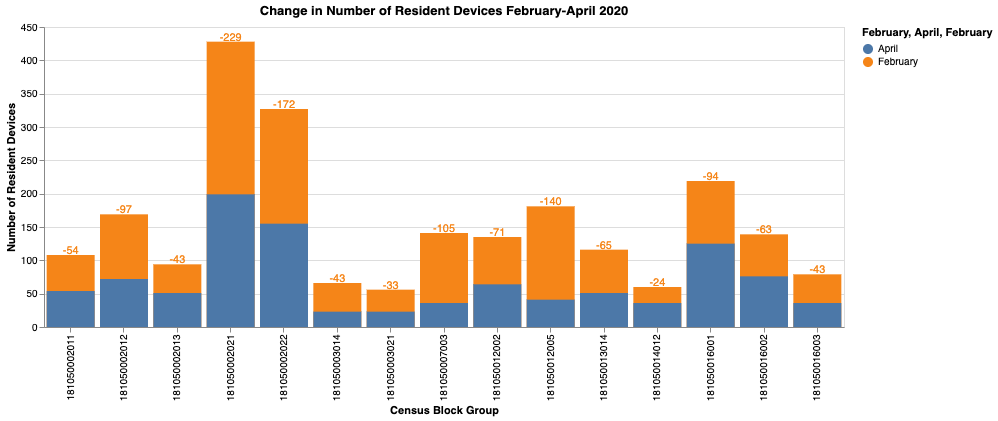

In [89]:
# Chart the difference in population in an Altair scatter plot

feb_chart = alt.Chart(bton_transient_cbg_devices).mark_bar(color='red').encode(
    alt.X('census_block_group:N',
         axis=alt.Axis(title='Census Block Group')),
    alt.Y('devices02032020:Q',
        axis=alt.Axis(
         title='Number of Resident Devices'
        )
    ),
    color=alt.Color('month_x', legend=alt.Legend(title="February"))
)

april_chart = alt.Chart(bton_transient_cbg_devices).mark_bar().encode(
    alt.X('census_block_group:N',
         axis=alt.Axis(title='Census Block Group')
         ),
    alt.Y('devices04132020:Q',
         axis=alt.Axis(
         title='Number of Resident Devices'
        )
    ),
    color=alt.Color('month_y', legend=alt.Legend(title="April"))
).properties(
    width=800,
    title='Change in Number of Resident Devices in Transient CBGs February-April 2020')

pct_change_chart_text = feb_chart.mark_text(dy=-4).encode(text='pop_change:Q')

feb_chart + april_chart + pct_change_chart_text